# Ungraded Lab: Feature Engineering with Accelerometer Data

This notebook demonstrates how to prepare time series data taken from an accelerometer. We will be using the [WISDM Human Activity Recognition Dataset](http://www.cis.fordham.edu/wisdm/dataset.php) for this example. This dataset can be used to predict the activity a user performs from a set of acceleration values recorded from the accelerometer data of a smartphone.

The dataset consists of accelerometer data in the x, y, and z-axis recorded for 36 user different users. A total of 6 activities like 'Walking','Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing' etc. were recorded. The sensors have a sampling rate of 20Hz which means there are 20 observations recorded per second.

## Imports

In [1]:
import tensorflow as tf
import tensorflow_transform as tft

from tfx.components import CsvExampleGen
from tfx.components import ExampleValidator
from tfx.components import SchemaGen
from tfx.components import StatisticsGen
from tfx.components import Transform

from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from google.protobuf.json_format import MessageToDict

import os
import pprint
import pandas as pd
import numpy as np
import urllib

pp = pprint.PrettyPrinter()

## Extract the Data

In [2]:
# Setup paths and filenames
working_dir = './data/'
TRANSFORM_TRAIN_FILENAME = 'transform_train'
TRANSFORM_TEST_FILENAME = 'transform_test'
TRANSFORM_TEMP_DIR = 'tft_temp'
INPUT_FILE = './data/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt'

In [3]:
# Extract the data
!tar -xvf ./data/human_activity/raw/WISDM_ar_latest.tar.gz -C ./data/human_activity/raw/

WISDM_ar_v1.1/
WISDM_ar_v1.1/readme.txt
WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt
WISDM_ar_v1.1/WISDM_ar_v1.1_raw_about.txt
WISDM_ar_v1.1/WISDM_ar_v1.1_transformed.arff
WISDM_ar_v1.1/WISDM_ar_v1.1_trans_about.txt


## Inspect the Dataset

### Utilities

Since this is accelerometer data, it would be good to visualize different aspects of the measurements. You can look at the frequency of activities, or plot the measurements against time. These utility functions will help in doing that.

In [4]:
# Visulaization Utilities
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot

def visualize_value_plots_for_categorical_feature(feature, colors=['b']):
    '''Plots a bar graph for categorical features'''
    counts = feature.value_counts()
    plt.bar(counts.index, counts.values, color=colors)
    plt.show()


def visualize_plots(dataset, activity, columns):
    '''Visualizes the accelerometer data against time'''
    features = dataset[dataset['activity'] == activity][columns][:200]
    if 'z-acc' in columns:
        features['z-acc'] = features['z-acc'].replace(regex=True, to_replace=r';', value=r'')
        features['z-acc'] = features['z-acc'].astype(np.float64)
    axis = features.plot(subplots=True, figsize=(16, 12), 
                     title=activity)

    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

### Clean the data

You will also need to clean stray characters that may misrepresent your data. For this particular dataset, there is a semicolon at the end of each row and this will cause the z-acceleration to be interpreted as a string. Let's clean that up in the cells below.

In [5]:
# Set up paths
RAW_DATA_PATH = 'data/human_activity/raw/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt'
CLEAN_DATA_PATH = 'data/human_activity/pipeline_data'

# Create clean data path (raw data path already exists)
!mkdir {CLEAN_DATA_PATH}

In [6]:
# Preview the dataset. See the semicolon at the end of each line.
!head data/human_activity/raw/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt

In [7]:
# Load the dataset and set the column names
df = pd.read_csv(RAW_DATA_PATH, header=None, names=['user_id', 'activity', 'timestamp', 'x-acc','y-acc', 'z-acc'])

# Remove semicolon at the end of every row
df['z-acc'] = df['z-acc'].replace({';':''}, regex=True)

# Write the file to the clean data path
df.to_csv(f'{CLEAN_DATA_PATH}/human_activity.csv', index=False)

In [8]:
# See the results. The semicolon should now be removed.
!head {CLEAN_DATA_PATH}/human_activity.csv

user_id,activity,timestamp,x-acc,y-acc,z-acc
33,Jogging,49105962326000,-0.6946376999999999,12.680544,0.50395286
33,Jogging,49106062271000,5.012288,11.264028,0.95342433
33,Jogging,49106112167000,4.903325,10.882658000000001,-0.08172209
33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172
33,Jogging,49106332290000,-1.1849703,12.108489,7.205164
33,Jogging,49106442306000,1.3756552,-2.4925237,-6.510526
33,Jogging,49106542312000,-0.61291564,10.56939,5.706926
33,Jogging,49106652389000,-0.50395286,13.947235999999998,7.0553403
33,Jogging,49106762313000,-8.430995,11.413852,5.134871


### Histogram of Activities

You can now proceed with the visualizations. You can plot the histogram of activities and make your observations. For instance, you'll notice that there is more data for walking and jogging than other activities. This might have an effect on how your model learns each activity so you should take note of it.

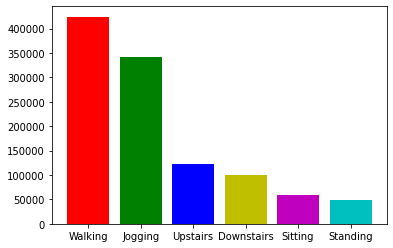

In [9]:
# Plot the histogram of activities
visualize_value_plots_for_categorical_feature(df['activity'], colors=['r', 'g', 'b', 'y', 'm', 'c'])

### Histogram of Measurements per User
You can also observe the number of measurements taken per user. From the plot below, you can see that for the 36 users in the study, the number of observations per user is mostly steady except for a few.

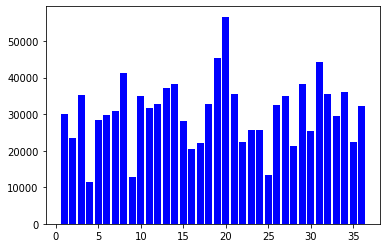

In [10]:
# Plot the histogram for users
visualize_value_plots_for_categorical_feature(df['user_id'])

### Acceleration per Activity

Finally, you can plot the sensor measurements against the timestamps. You can observe that acceleration is more for activities like jogging when compared to sitting which should be the expected behaviour. If this is not the case, then there might be problems with the sensor and can make the data invalid.

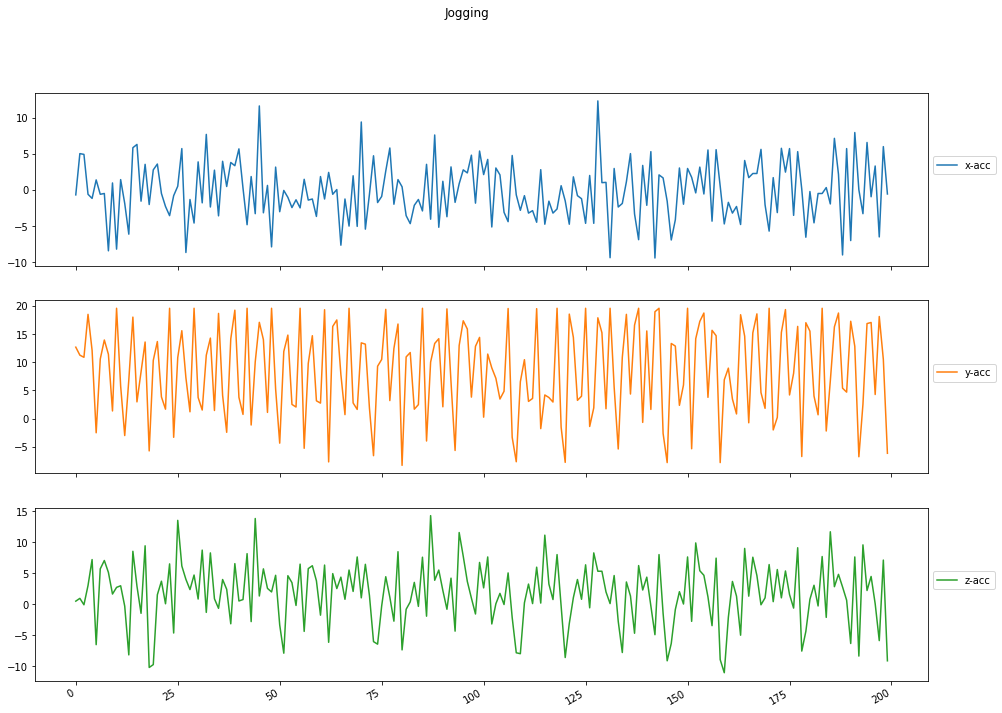

In [11]:
# Plot the measurements for `Jogging`
visualize_plots(df, 'Jogging', columns=['x-acc', 'y-acc', 'z-acc'])

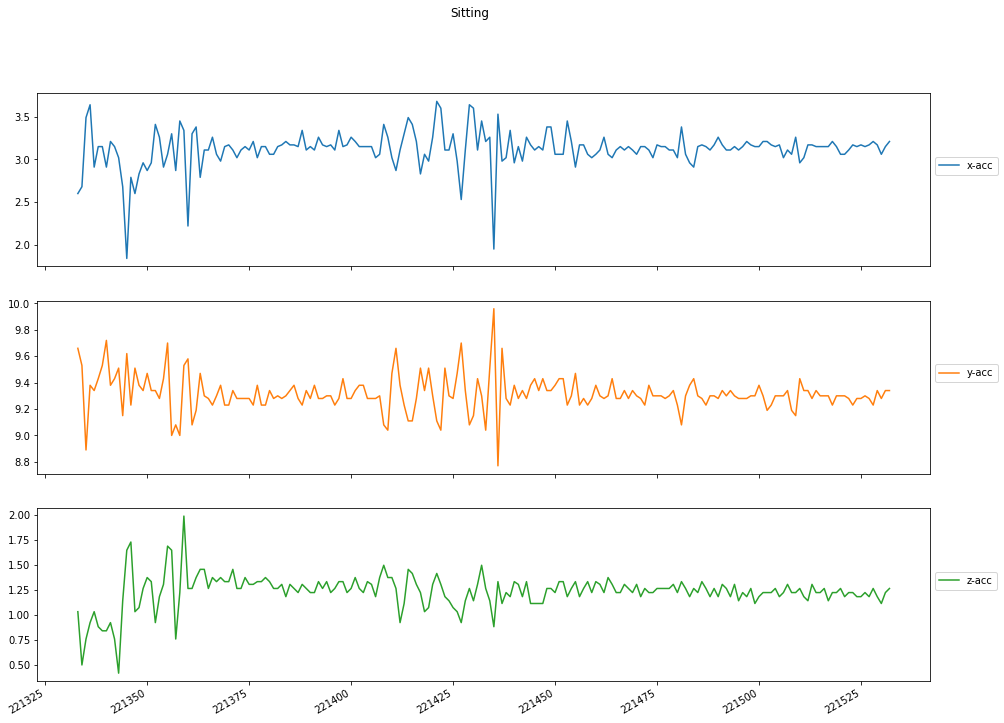

In [12]:
# Plot the measurements for `Sitting`
visualize_plots(df, 'Sitting', columns=['x-acc', 'y-acc', 'z-acc'])

## Data Pipeline

You can now feed the data into the TFX pipeline. As in the previous labs, we won't go over too much on the first few stages of the pipeline since you've already done it before.

In [13]:
# location of the pipeline metadata store
_pipeline_root = './pipeline/'

# directory of the raw data files
_data_root = './data/human_activity/pipeline_data'

In [14]:
# Initialize the InteractiveContext.
# If you leave `_pipeline_root` blank, then the db will be created in a temporary directory.
context = InteractiveContext(pipeline_root=_pipeline_root)

### ExampleGen

In [15]:
# Instantiate ExampleGen with the input CSV dataset
example_gen = CsvExampleGen(input_base=_data_root)

# Execute the component
context.run(example_gen)

ExecutionResult(
    component_id: CsvExampleGen
    execution_id: 1
    outputs:
        examples: Channel(
            type_name: Examples
            artifacts: [Artifact(artifact: id: 1
        type_id: 5
        uri: "./pipeline/CsvExampleGen/examples/1"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "input_fingerprint"
          value {
            string_value: "split:single_split,num_files:1,total_bytes:48260814,xor_checksum:1621714567,sum_checksum:1621714567"
          }
        }
        custom_properties {
          key: "payload_format"
          value {
            string_value: "FORMAT_TF_EXAMPLE"
          }
        }
        custom_properties {
          key: "span"
          value {
            string_value: "0"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        , artifact_type: id: 5
        name: "Examples"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        properties {
          key: "version"
          value: INT
        }
        )]
        ))

### Preview the Ingested Dataset

In [16]:
# get the artifact object
artifact = example_gen.outputs['examples'].get()[0]

# print split names and uri
print(f'split names: {artifact.split_names}')
print(f'artifact uri: {artifact.uri}')

split names: ["train", "eval"]
artifact uri: ./pipeline/CsvExampleGen/examples/1


In [17]:
# Get the URI of the output artifact representing the training examples
train_uri = os.path.join(artifact.uri, 'train')

# See the contents of the `train` folder
!ls {train_uri}

data_tfrecord-00000-of-00001.gz


In [18]:
# Get the list of files in this directory (all compressed TFRecord files)
tfrecord_filenames = [os.path.join(train_uri, name)
                      for name in os.listdir(train_uri)]

# Create a `TFRecordDataset` to read these files
dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")

In [19]:
# Define a helper function to get individual examples
def get_records(dataset, num_records):
    '''Extracts records from the given dataset.
    Args:
        dataset (TFRecordDataset): dataset saved by ExampleGen
        num_records (int): number of records to preview
    '''
    
    # initialize an empty list
    records = []
    
    # Use the `take()` method to specify how many records to get
    for tfrecord in dataset.take(num_records):
        
        # Get the numpy property of the tensor
        serialized_example = tfrecord.numpy()
        
        # Initialize a `tf.train.Example()` to read the serialized data
        example = tf.train.Example()
        
        # Read the example data (output is a protocol buffer message)
        example.ParseFromString(serialized_example)
        
        # convert the protocol bufffer message to a Python dictionary
        example_dict = (MessageToDict(example))
        
        # append to the records list
        records.append(example_dict)
        
    return records

In [20]:
# Get 3 records from the dataset
sample_records = get_records(dataset, 3)

# Print the output
pp.pprint(sample_records)

[{'features': {'feature': {'activity': {'bytesList': {'value': ['Sm9nZ2luZw==']}},
                           'timestamp': {'int64List': {'value': ['49106062271000']}},
                           'user_id': {'int64List': {'value': ['33']}},
                           'x-acc': {'floatList': {'value': [5.012288]}},
                           'y-acc': {'floatList': {'value': [11.264028]}},
                           'z-acc': {'floatList': {'value': [0.95342433]}}}}},
 {'features': {'feature': {'activity': {'bytesList': {'value': ['Sm9nZ2luZw==']}},
                           'timestamp': {'int64List': {'value': ['49106112167000']}},
                           'user_id': {'int64List': {'value': ['33']}},
                           'x-acc': {'floatList': {'value': [4.903325]}},
                           'y-acc': {'floatList': {'value': [10.882658]}},
                           'z-acc': {'floatList': {'value': [-0.08172209]}}}}},
 {'features': {'feature': {'activity': {'bytesList': {'value'

### StatisticsGen

In [21]:
# Instantiate StatisticsGen with the ExampleGen ingested dataset
statistics_gen = StatisticsGen(
    examples=example_gen.outputs['examples'])

# Execute the component
context.run(statistics_gen)

ExecutionResult(
    component_id: StatisticsGen
    execution_id: 7
    outputs:
        statistics: Channel(
            type_name: ExampleStatistics
            artifacts: [Artifact(artifact: id: 9
        type_id: 8
        uri: "./pipeline/StatisticsGen/statistics/7"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "statistics"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "StatisticsGen"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        , artifact_type: id: 8
        name: "ExampleStatistics"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        )]
        ))

In [22]:
# Show the output statistics
context.show(statistics_gen.outputs['statistics'])

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


### SchemaGen

In [23]:
# Instantiate SchemaGen with the StatisticsGen ingested dataset
schema_gen = SchemaGen(
    statistics=statistics_gen.outputs['statistics'],
    )

# Run the component
context.run(schema_gen)

ExecutionResult(
    component_id: SchemaGen
    execution_id: 8
    outputs:
        schema: Channel(
            type_name: Schema
            artifacts: [Artifact(artifact: id: 10
        type_id: 10
        uri: "./pipeline/SchemaGen/schema/8"
        custom_properties {
          key: "name"
          value {
            string_value: "schema"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "SchemaGen"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        , artifact_type: id: 10
        name: "Schema"
        )]
        ))

In [24]:
# Visualize the schema
context.show(schema_gen.outputs['schema'])

,Type,Presence,Valency,Domain
Feature name,,,,
'activity',STRING,required,single,'activity'
'timestamp',INT,required,single,-
'user_id',INT,required,single,-
'x-acc',FLOAT,required,single,-
'y-acc',FLOAT,required,single,-
'z-acc',FLOAT,required,"[0,1]",-


,Values
Domain,
'activity',"'Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking'"


### ExampleValidator

In [25]:
# Instantiate ExampleValidator with the StatisticsGen and SchemaGen ingested data
example_validator = ExampleValidator(
    statistics=statistics_gen.outputs['statistics'],
    schema=schema_gen.outputs['schema'])

# Run the component.
context.run(example_validator)

ExecutionResult(
    component_id: ExampleValidator
    execution_id: 9
    outputs:
        anomalies: Channel(
            type_name: ExampleAnomalies
            artifacts: [Artifact(artifact: id: 11
        type_id: 12
        uri: "./pipeline/ExampleValidator/anomalies/9"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "anomalies"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "ExampleValidator"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        , artifact_type: id: 12
        name: "ExampleAnomalies"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        )]
        ))

In [26]:
# Visualize the results
context.show(example_validator.outputs['anomalies'])

### Transform

In [27]:
# Set the constants module filename
_activity_constants_module_file = 'activity_constants.py'

In [28]:
%%writefile {_activity_constants_module_file}

# Numerical features that are marked as continuous
INT_FEATURES = ['user_id', 'timestamp']

# Feature that can be grouped into buckets
FLOAT_FEATURES = ['x-acc', 'y-acc', 'z-acc']

# Feature that the model will predict
LABEL_KEY = 'activity'

# Utility function for renaming the feature
def transformed_name(key):
    return key + '_xf'

Writing activity_constants.py


In [29]:
# Set the transform module filename
_activity_transform_module_file = 'activity_transform.py'

In [30]:
%%writefile {_activity_transform_module_file}

import tensorflow as tf
import tensorflow_transform as tft

import activity_constants
import importlib

importlib.reload(activity_constants)

# Unpack the contents of the constants module
_INT_FEATURES = activity_constants.INT_FEATURES
_FLOAT_FEATURES = activity_constants.FLOAT_FEATURES
_LABEL_KEY = activity_constants.LABEL_KEY
_transformed_name = activity_constants.transformed_name


# Define the transformations
def preprocessing_fn(inputs):
    """tf.transform's callback function for preprocessing inputs.
    Args:
        inputs: map from feature keys to raw not-yet-transformed features.
    Returns:
        Map from string feature key to transformed feature operations.
    """
    outputs = {}

    outputs[_transformed_name(_LABEL_KEY)] = tft.compute_and_apply_vocabulary(inputs[_LABEL_KEY],vocab_filename=_LABEL_KEY)

    for key in _FLOAT_FEATURES:
        outputs[_transformed_name(key)] = tft.scale_by_min_max(inputs[key])

    return outputs

Writing activity_transform.py


In [31]:
# Ignore TF warning messages
tf.get_logger().setLevel('ERROR')

# Instantiate the Transform component
transform = Transform(
    examples=example_gen.outputs['examples'],
    schema=schema_gen.outputs['schema'],
    module_file=os.path.abspath(_activity_transform_module_file))

# Run the component
context.run(transform)

ExecutionResult(
    component_id: Transform
    execution_id: 10
    outputs:
        transform_graph: Channel(
            type_name: TransformGraph
            artifacts: [Artifact(artifact: id: 12
        type_id: 14
        uri: "./pipeline/Transform/transform_graph/10"
        custom_properties {
          key: "name"
          value {
            string_value: "transform_graph"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        , artifact_type: id: 14
        name: "TransformGraph"
        )]
        )
        transformed_examples: Channel(
            type_name: Examples
            artifacts: [Artifact(artifact: id: 13
        type_id: 5
        uri: "./pipeline/Transform/transformed_examples/10"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "transformed_examples"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        , artifact_type: id: 5
        name: "Examples"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        properties {
          key: "version"
          value: INT
        }
        )]
        )
        updated_analyzer_cache: Channel(
            type_name: TransformCache
            artifacts: [Artifact(artifact: id: 14
        type_id: 15
        uri: "./pipeline/Transform/updated_analyzer_cache/10"
        custom_properties {
          key: "name"
          value {
            string_value: "updated_analyzer_cache"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        , artifact_type: id: 15
        name: "TransformCache"
        )]
        ))

In [32]:
# Get the URI of the output artifact representing the transformed examples
train_uri = os.path.join(transform.outputs['transformed_examples'].get()[0].uri, 'train')

# Get the list of files in this directory (all compressed TFRecord files)
tfrecord_filenames = [os.path.join(train_uri, name)
                      for name in os.listdir(train_uri)]

# Create a `TFRecordDataset` to read these files
transformed_dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")

In [33]:
# Get 3 records from the dataset
sample_records_xf = get_records(transformed_dataset, 3)

# Print the output
pp.pprint(sample_records_xf)

[{'features': {'feature': {'activity_xf': {'int64List': {'value': ['1']}},
                           'x-acc_xf': {'floatList': {'value': [0.6224036]}},
                           'y-acc_xf': {'floatList': {'value': [0.77866393]}},
                           'z-acc_xf': {'floatList': {'value': [0.526603]}}}}},
 {'features': {'feature': {'activity_xf': {'int64List': {'value': ['1']}},
                           'x-acc_xf': {'floatList': {'value': [0.61964923]}},
                           'y-acc_xf': {'floatList': {'value': [0.76904553]}},
                           'z-acc_xf': {'floatList': {'value': [0.5003369]}}}}},
 {'features': {'feature': {'activity_xf': {'int64List': {'value': ['1']}},
                           'x-acc_xf': {'floatList': {'value': [0.48020944]}},
                           'y-acc_xf': {'floatList': {'value': [0.96107006]}},
                           'z-acc_xf': {'floatList': {'value': [0.5791352]}}}}}]


## Prepare Dataset Window

Now that you have the transformed examples, you now need to prepare the dataset window for this time series data. As discussed in class, you want to group a series of measurements and that will be the feature for a particular label. In this particular case, it makes sense to group consecutive measurements and use that as the indicator for an activity. For example, if you take 80 measurements and it oscillates greatly (just like in the visualizations in the earlier parts of this notebook), then the model should be able to tell that it is a 'Running' activity. Let's implement that in the following cells using the [tf.data.Dataset.window()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#window) method.

In [34]:
# Get the URI of the output graph
transform_graph_uri = transform.outputs['transform_graph'].get()[0].uri

# Wrap output graph with TFTTransformOutput
tf_transform_output = tft.TFTransformOutput(transform_graph_uri)

In [35]:
# Parameters
HISTORY_SIZE = 80
BATCH_SIZE = 100
SHIFT = 40

# Helper functions
def parse_function(example_proto):
    '''Parse the values from tf examples'''
    feature_spec = tf_transform_output.transformed_feature_spec()
    features = tf.io.parse_single_example(example_proto, feature_spec)
    values = list(features.values())
    values = [float(_fill_in_missing(value)) for value in values]    
    features = tf.stack(values, axis=0)
    return features

def add_mode(features):
    '''Calculate mode of activity for the current history size of elements'''
    features = tf.squeeze(features)
    unique, _, count = tf.unique_with_counts(features[:,0])
    max_occurrences = tf.reduce_max(count)
    max_cond = tf.equal(count, max_occurrences)
    max_numbers = tf.squeeze(tf.gather(unique, tf.where(max_cond)))

    #Features (X) are all features except activity (x-acc, y-acc, z-acc)
    #Target(Y) is the mode of activity values of all rows in this window
    return (features[:,1:], max_numbers)

def get_dataset(path):
    '''Get the dataset and group them into windows'''
    dataset = tf.data.TFRecordDataset(path, compression_type="GZIP")
    dataset = dataset.map(parse_function)
    dataset = dataset.window(HISTORY_SIZE, shift=SHIFT, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(HISTORY_SIZE))

    dataset = dataset.map(add_mode)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.repeat()

    return dataset

def _fill_in_missing(x):
    """Replace missing values in a SparseTensor.
    Fills in missing values of `x` with '' or 0, and converts to a dense tensor.
    Args:
    x: A `SparseTensor` of rank 2.  Its dense shape should have size at most 1
      in the second dimension.
    Returns:
    A rank 1 tensor where missing values of `x` have been filled in.
    """
    default_value = '' if x.dtype == tf.string else 0
    return tf.sparse.to_dense(x, default_value)

In [36]:
# Get the URI of the transformed examples
working_dir = transform.outputs['transformed_examples'].get()[0].uri

# Get the filename of the compressed examples
train_tfrecord_files = os.listdir(working_dir + '/train')[0]

# Full path string to the training tfrecord files
path_to_train_tfrecord_files = os.path.join(working_dir, 'train', train_tfrecord_files)

# Get the window datasets by passing the full path to the get_dataset function
train_dataset = get_dataset(path_to_train_tfrecord_files)

# Preview the results for 1 record
for x, y in train_dataset.take(1):
    print("\nFeatures (x-acc, y-acc, z-acc):\n")
    print(x)
    print("\nTarget (activity):\n")
    print(y)


Features (x-acc, y-acc, z-acc):

tf.Tensor(
[[[0.6224036  0.77866393 0.526603  ]
  [0.61964923 0.76904553 0.5003369 ]
  [0.48020944 0.96107006 0.5791352 ]
  ...
  [0.37554345 0.9621006  0.42361233]
  [0.5411498  0.8580158  0.52971345]
  [0.47538927 0.57667744 0.6036732 ]]

 [[0.48020944 0.9071384  0.6278657 ]
  [0.49673563 0.9359936  0.5666933 ]
  [0.30220842 0.6917548  0.6133502 ]
  ...
  [0.63996273 0.60072345 0.54215527]
  [0.40653008 0.6975945  0.48685828]
  [0.62928957 0.9071384  0.73362124]]

 [[0.46471608 0.5952273  0.52280134]
  [0.3786421  0.5430131  0.71253926]
  [0.806602   0.9456119  0.63754267]
  ...
  [0.45404294 0.8607639  0.5480306 ]
  [0.4309751  0.7158008  0.46854115]
  [0.15278398 0.6337009  0.6092029 ]]

 ...

 [[0.6186164  0.8336263  0.8134563 ]
  [0.31770173 0.78725183 0.63270414]
  [0.33491653 0.3891186  0.32269523]
  ...
  [0.62756807 0.8810313  0.68523633]
  [0.55767596 0.6780142  0.39250773]
  [0.69711584 0.8964894  0.62682885]]

 [[0.8702967  0.9390852  0.65

You should see a sample of a dataset window above. There are 80 consecutive measurements of `x-acc`, `y-acc`, and `z-acc` that correspond to a single labeled activity. Moreover, you also set it up to be in batches of 100 windows. This can now be fed to train an LSTM so it can learn how to detect activities based on 80-measurement windows.

## Wrap Up

In this lab, you were able to prepare time-series data from an accelerometer to transformed features that are grouped into windows to make predictions. The same concept can be applied to any data where it makes sense to take a few seconds of measurements before the model makes a prediction. 